In [1]:
import pickle as pkl
from scipy import stats
from scipy import optimize
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from utils import *
def f_1(x, A, B):
    return A * x + B
def func(x, a, b, c):
    return a * np.exp(b * x) + c

In [2]:
'loading parameters..'
with open('./data/params_US.pkl', 'rb') as f:
    params = pkl.load(f)
B_usa = params['B']
C_usa = params['C']

with open('./data/params_ch.pkl', 'rb') as f:
    params = pkl.load(f)
B_ch = params['B']
C_ch = params['C']

with open('./data/params_EUR.pkl', 'rb') as f:
    params = pkl.load(f)
B_eur = params['B']
C_eur = params['C']

bi_usa = B_usa['ni'][0]
ci_usa = C_usa['ni'][0]
bl_usa = B_usa['lt'][0]
cl_usa = C_usa['lt'][0]

bi_ch = B_ch['ni'][0]
ci_ch = C_ch['ni'][0]
bl_ch = B_ch['lt'][0]
cl_ch = C_ch['lt'][0]

bi_eur = B_eur['mean_ni'][0]
ci_eur = C_eur['mean_ni'][0]
bl_eur = B_eur['lt'][0]
cl_eur = C_eur['lt'][0]

In [12]:
'loading data..'
data_usa = pd.read_csv('./samples_usa.csv')
data_usa.sort_values('fyear', ascending = True, inplace=True)

data_eur = pd.read_csv('./samples_eur.csv')
data_eur.sort_values('fyear', ascending = True, inplace=True)

data_ch = pd.read_csv('./samples_ch.csv')
data_ch.sort_values('fyear', ascending = True, inplace=True)


In [13]:
'setting alpha'
alpha_usa = 0#0.55
alpha_ch = 0#.48 
alpha_eur = 0#.97


In [14]:
'inverse function'
def function_mapping(beta,c_const,beta_l,c_const_l):
#     %this function determine which type of functional form, types of concave
#     % and the critical point of size according to the parameters of the market
    
#     % beta: power law exponent of net income
#     % c_const: power law intercept of net income
#     % beta_l: power law exponent of liability
#     % c_const_l: power law intercept of liability
#     % ff: functional form
#     % concave: 1 for A''(t)>0, 0 for A''(t)<0, and -1 for A(t) is exponential
    c_const = np.e**c_const
    c_const_l = np.e**c_const_l
    onebeta = 1 - beta
    oneminus = onebeta * c_const_l * beta_l / (beta_l - beta)
    betac = onebeta * c_const
    betalminus = beta_l - 1

    def f1(x):
        return pow(x, onebeta) * (1 - oneminus * pow(x, betalminus)) / betac
    def f2(x):
        return ((np.log(x) - pow(x, betalminus) * beta_l * c_const_l / betalminus)) / c_const
    def f3(x):
        return np.log(x) * (1 - c_const_l) / (c_const)
    def f4(x):
        return pow(x, onebeta) * (1-oneminus * pow(x,betalminus)) / betac
    def f5(x):
        return pow(x, onebeta) / betac - beta * c_const_l * np.log(x) / c_const
    ff=f1
    if abs(beta-1) < 0.01:
        ff = f2
        if abs(beta_l-1) < 0.01:
            ff = f3
    if beta > 1 or beta > beta_l:
        ff = f4
    if abs(beta-beta_l) < 0.01:
        ff = f5
#   if beta_l<>1, then calculate concave
    if abs(beta_l-1) > 0.01 and c_const_l > 0 and beta_l > 0:
#         solving astar: dA/dt=cA^b/(1-cl bl A^(bl-1))=0
        astar = np.exp((np.log(c_const_l) + np.log(beta_l)) / (1 - beta_l))
        # solving concave by d^2A/dt^2>0
        concave = beta * pow(astar,(1 - beta_l)) > c_const_l * beta_l * (-beta_l + beta + 1)
    else:
        astar=np.nan
        concave=-1
    return ff,concave,astar

def get_parameter(beta,c_const,beta_l,c_const_l):
    c_const_l = np.exp(c_const_l)
    c_const = np.exp(c_const)
    
    str_term=1-((1-beta_l)/(1-beta))*(c_const_l/(1-c_const_l)); 
    growth_exponent = str_term / (1-beta);#gama
    
#     print((1-beta)*c_const/(1-c_const_l))
    
    term1 = (1/(1-beta))*np.log((1-beta)*c_const/(1-c_const_l))*str_term;
    term2 = beta*(1-str_term)/(1-beta);
    growth_constant = (term1+term2)#/(c_const*(1-beta)); #c
#     growth_constant = np.exp(growth_constant)
    return growth_exponent,growth_constant

## 'universal function for all markets'

6.785553701115029 -9.923262866421389
6.086853360544491 -10.059043301771949
4.344907293836879 0.36504944832534364


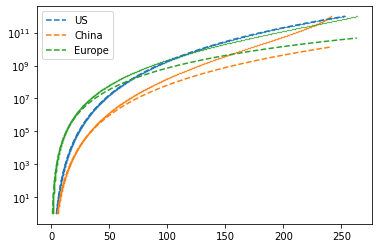

In [15]:


'US'
tuned_C_usa = np.log(np.exp(ci_usa)*(1-alpha_usa))
ff_usa,concave_usa,astar_usa = function_mapping(bi_usa,tuned_C_usa,bl_usa,cl_usa)
size_range_usa=np.logspace(0,12,1000);
'ff is inverse function'
time_range_usa=ff_usa(size_range_usa)
plt.scatter(time_range_usa,size_range_usa,s=0.1)
'power law'
gama_usa, c_usa = get_parameter(bi_usa,tuned_C_usa,bl_usa,cl_usa)
plt.plot(time_range_usa, time_range_usa**gama_usa * np.exp(c_usa), '--',label='US')
print(gama_usa, c_usa)
plt.yscale('log')


'ch'
tuned_C_ch = np.log(np.exp(ci_ch)*(1-alpha_ch))#
ff_ch,concave_ch,astar_ch = function_mapping(bi_ch,tuned_C_ch,bl_ch,cl_ch)
data_noAT_NAN = data_ch.dropna(axis=0, how='any',subset=['inf_at'], inplace=False)
size_range_ch=np.logspace(0,12,1000);
time_range_ch=ff_ch(size_range_ch)#, pow(size_range, mean_bi) * np.exp(mean_ci))

plt.scatter(time_range_ch, size_range_ch,s=0.1)
plt.yscale('log')
betac = np.exp(tuned_C_ch) * (1 - bi_ch)
gama_ch, c_ch = get_parameter(bi_ch,tuned_C_ch,bl_ch,cl_ch)
plt.plot(time_range_ch, time_range_ch**gama_ch * np.exp(c_ch), '--',label='China')
print(gama_ch,c_ch)


'eur'
tuned_C_eur = np.log(np.exp(ci_eur)*(1-alpha_eur))#
ff_eur,concave_eur,astar_eur = function_mapping(bi_eur,tuned_C_eur,bl_eur,cl_eur)
data_noAT_NAN = data_eur.dropna(axis=0, how='any',subset=['inf_at'], inplace=False)
size_range_eur=np.logspace(0,12,1000);
time_range_eur=ff_eur(size_range_eur)#, pow(size_range, mean_bi) * np.exp(mean_ci))

plt.scatter(time_range_eur, size_range_eur,s=0.1)
plt.yscale('log')
betac = np.exp(tuned_C_eur) * (1 - bi_eur)
gama_eur, c_eur = get_parameter(bi_eur,tuned_C_eur,bl_eur,cl_eur)
plt.plot(time_range_eur, time_range_eur**gama_eur * np.exp(c_eur), '--',label='Europe')
print(gama_eur,c_eur)
plt.legend()
plt.show()



## universal function for seperate market visualization

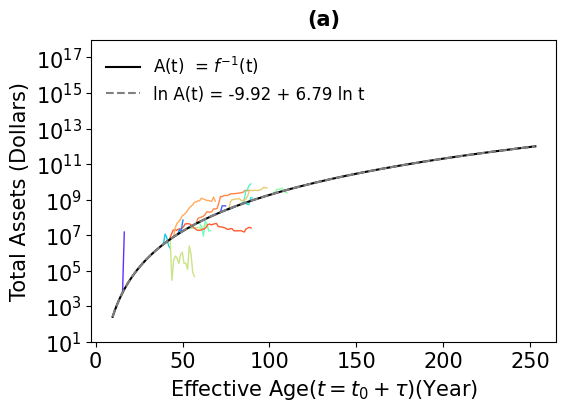

In [20]:
'us'
lsty = {}
group_com = data_usa.groupby('gvkey')
for index,(i,df) in enumerate(group_com):
    lsty[i] = len(df)
lsty = sorted(lsty.items(), key = lambda kv:(kv[1]))
lsty = [i[0] for i in lsty]

'binned'
plt.figure(dpi=100)

data_usa = data_usa[data_usa['inf_at']>0]
group_com = data_usa.groupby('gvkey')
colors = sns.color_palette("rainbow",len(lsty)+1)

for index,(i,df) in enumerate(group_com):
    y = df['inf_at'].values
    t0 = ff_usa(y[0])
    t_arr = np.array([j + t0 for j in range(len(df))])
#     print(t_arr)
    plt.plot(t_arr, y, alpha=1, linewidth=1, c=colors[lsty.index(i)])

plt.plot(time_range_usa[200:],size_range_usa[200:],c='k',label=r'A(t)  = $f^{-1}$(t)',zorder=300000)

'power law prediction'
predict_y = gama_usa * np.log(time_range_usa[200:]) + c_usa
plt.plot(time_range_usa[200:], np.exp(predict_y), '--',c='gray',zorder=300000,label=f'ln A(t) = {c_usa:.2f} + {gama_usa:.2f} ln t')

fontsize = 15
plt.xlabel(r'Effective Age($t=t_0 + \tau$)(Year)',fontsize=fontsize)
plt.ylabel('Total Assets (Dollars)',fontsize=fontsize)
# plt.title('(a).Generalized Growth Curve of US',fontsize=fontsize,fontweight='heavy',y=1.02)
plt.yscale('log')
plt.title('(a)',fontsize=fontsize,fontweight='heavy',y=1.02)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.legend(fontsize=fontsize-3,loc=2,edgecolor='none')
# plt.legend(handles=legend_elements,fontsize=fontsize-3,loc=2,edgecolor='none')
plt.ylim(1e+1,1e+18)
plt.show()


In [21]:
len(group_com)

15

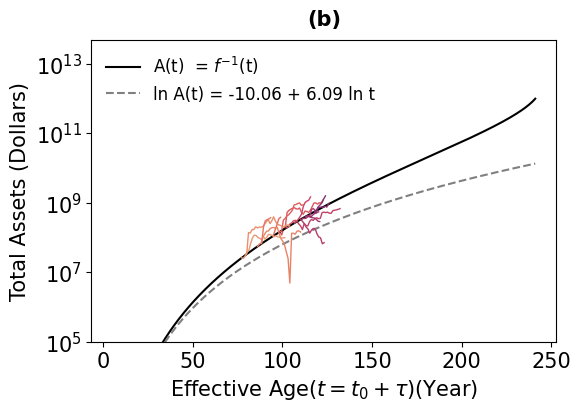

In [22]:
'ch'
lsty = []
aaa = data_ch.drop_duplicates(['gvkey']).copy()
aaa.sort_values('fyear', ascending = True, inplace=True)
aaa['rank'] = aaa['inf_at'].rank()
group_com = data_ch.groupby('gvkey')
for index,(i,df) in enumerate(group_com):
    rank = aaa[aaa['gvkey']==i]['rank'].values[0]
    df['rank'] = [rank for i in range(len(df))]
    lsty.append(df)
eq_ch_df = pd.concat(lsty)

'binned'
plt.figure(dpi=100)
eq_ch_df = eq_ch_df[eq_ch_df['inf_at']>0]
group_com = eq_ch_df.groupby('gvkey')
colors = sns.color_palette("flare",len(lsty)+1)

# betac = np.exp(C_ch['ni'][0]) * (1-B_ch['ni'][0])

for index,(i,df) in enumerate(group_com):
    y = df['inf_at'].values
    df_t0 = ff_ch(y[0])
        
    if np.isnan(sum(y)) == False and np.isinf(sum(y)) == False and np.isnan(df['rank'].values[0]) ==False:
        t_arr = [j + df_t0 for j in range(len(df))]
        c_index = int(df['rank'].values[0])

        plt.plot(t_arr, y,alpha=1, linewidth=1,c=colors[c_index],zorder=index)
plt.plot(time_range_ch,size_range_ch,c='k',label=r'A(t)  = $f^{-1}$(t)')

'power law prediction'
predict_y = gama_ch * np.log(time_range_ch) + c_ch
plt.plot(time_range_ch, np.exp(predict_y), '--',c='gray',label=f'ln A(t) = {c_ch:.2f} + {gama_ch:.2f} ln t')

fontsize = 15
plt.xlabel(r'Effective Age($t=t_0 + \tau$)(Year)',fontsize=fontsize)
# plt.xlabel(r'Rescaled time $c_I(1-\beta_I)(1-\alpha) t$',fontsize=fontsize)
plt.ylabel('Total Assets (Dollars)',fontsize=fontsize)
# plt.title('(a).Generalized Growth Curve of US',fontsize=fontsize,fontweight='heavy',y=1.02)
plt.yscale('log')
plt.title('(b)',fontsize=fontsize,fontweight='heavy',y=1.02)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.legend(fontsize=fontsize-3,loc=2,edgecolor='none')
# plt.legend(handles=legend_elements,fontsize=fontsize-3,loc=2,edgecolor='none')
plt.ylim(1e+5,5e+13)
plt.show()


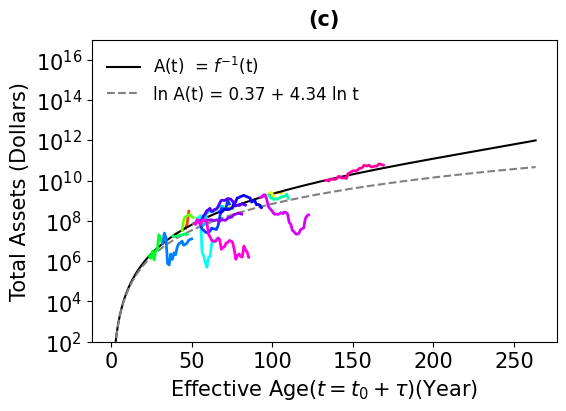

In [23]:
'eur'

lsty = {}
group_com = data_eur.groupby('gvkey')
for index,(i,df) in enumerate(group_com):
    lsty[i] = len(df)
lsty = sorted(lsty.items(), key = lambda kv:(kv[1]))
lsty = [i[0] for i in lsty]

'binned'
plt.figure(dpi=100)

data_eur = data_eur[data_eur['inf_at']>0]
group_com = data_eur.groupby('gvkey')
colors = sns.color_palette("hsv",len(lsty)+1)

for index,(i,df) in enumerate(group_com):
    y = df['inf_at'].values
    df_t0 = ff_eur(y[0])
    t_arr = np.array([j + df_t0 for j in range(len(df))])
    plt.plot(t_arr, y, alpha=1, linewidth=2, c=colors[lsty.index(i)], zorder=lsty.index(i))

plt.plot(time_range_eur,size_range_eur,c='k',label=r'A(t)  = $f^{-1}$(t)')

'power law prediction'
predict_y = gama_eur * np.log(time_range_eur) + c_eur
plt.plot(time_range_eur, np.exp(predict_y), '--',c='gray',label=f'ln A(t) = {c_eur:.2f} + {gama_eur:.2f} ln t')

fontsize = 15
plt.xlabel(r'Effective Age($t=t_0 + \tau$)(Year)',fontsize=fontsize)
# plt.xlabel(r'Rescaled time $c_I(1-\beta_I)(1-\alpha)t$',fontsize=fontsize)
plt.ylabel('Total Assets (Dollars)',fontsize=fontsize)
plt.yscale('log')
plt.title('(c)',fontsize=fontsize,fontweight='heavy',y=1.02)
plt.yticks(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.legend(fontsize=fontsize-3,loc=2,edgecolor='none')
plt.ylim(1e+2,1e+17)
plt.show()
